In [1]:
'''
short summary of the code below:
- any rows of the null data are dropped 
'''

'\nshort summary of the code below:\n- any rows of the null data are dropped \n'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


import time
import warnings
warnings.filterwarnings('ignore')

### Data description
- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### OBJECTIVE
Predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

SOURCE: https://www.kaggle.com/competitions/spaceship-titanic/overview

In [3]:
import os
# prepering directories
path = os.getcwd()
# subfolders
input_dir = os.path.join(path, 'data')
output_dir = os.path.join(path, 'outputs')

# Data Loading and basic exploration

In [4]:
train = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test = pd.read_csv(os.path.join(input_dir, 'test.csv'))

In [5]:
print( 'Number of rows', train.shape[0]  )
print( 'Number of columns', train.shape[1]  )

Number of rows 8693
Number of columns 14


In [6]:
print( 'Number of values per column' )
train.count()

Number of values per column


PassengerId     8693
HomePlanet      8492
CryoSleep       8476
Cabin           8494
Destination     8511
Age             8514
VIP             8490
RoomService     8512
FoodCourt       8510
ShoppingMall    8485
Spa             8510
VRDeck          8505
Name            8493
Transported     8693
dtype: int64

In [7]:
print('Total number of values in data', train.count().sum() )

Total number of values in data 119378


#### Basic data exploration and missing values 

In [8]:
# initializing new data frame that will be displayed in the table
dataset = train.copy()
data_review = pd.DataFrame(columns = ['Column','Data Type','Misssing Values', 'Missing Values [%]', 'Sum Unique Val'])



# looping via columns and extracting needed information
for index, column in enumerate(dataset.columns):
    data_type = dataset.dtypes[column]
    missing_value = dataset[column].isnull().sum()
    percentage = round((missing_value/len(dataset))* 100,1) if (missing_value/len(dataset))* 100 else 0
    unique_val = len(dataset[column].unique())
    data_review.loc[index] = [column, data_type, missing_value,percentage,unique_val]
    
pd.set_option("max_rows", None) # all rows are shown when printing  

    
data_review = data_review.sort_values(by=['Missing Values [%]'], ascending=False)
data_review.style\
        .bar(subset=["Misssing Values"], color='pink')\
        .bar(subset=["Sum Unique Val"], color='pink')\



,Column,Data Type,Misssing Values,Missing Values [%],Sum Unique Val
2,CryoSleep,object,217,2.500000,3
9,ShoppingMall,float64,208,2.400000,1116
1,HomePlanet,object,201,2.300000,4
3,Cabin,object,199,2.300000,6561
6,VIP,object,203,2.300000,3
12,Name,object,200,2.300000,8474
11,VRDeck,float64,188,2.200000,1307
4,Destination,object,182,2.100000,4
5,Age,float64,179,2.100000,81
7,RoomService,float64,181,2.100000,1274


#### Basic statistics of training data

In [9]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


#### Quick view of Train Data

In [10]:
train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
data = train.copy()
TARGET = 'Transported'
IDs = 'PassengerId'
FEATURES = [col for col in data.columns if col not in [TARGET, IDs] ] # excludes columns: target and IDs

In [12]:
data.describe().T.sort_values(by='std' , ascending = False).style\
    .bar(subset=["max"], color='salmon')\
    .bar(subset=["mean",], color='pink')\
    .bar(subset=["50%",], color='lightgray')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000


We are dealing with supervised machine learning and need to predict a discrete class/category label. In this case we have a binary classification - passenger transported True or False
Main classification types of algorithms in ML:
- decision trees
- naive bayes
- linear discriminant analysis
- k-nearest neighbor
- logistic regression
- neural network
- support vector machine

## KNN - k-nearest neighbor

Before running the algorithm, we need to prepare the data. Since KNN is a distance-based algorithm, we need to:
- convert categorical variables into numerical ones
- normalize data

## DATA REVIEW and ITS PREPARATION

### Question: drop all missing values or not?

In [13]:
print('Train Dataset =>')
droped_null_train = train.copy()
before_removing = droped_null_train.shape[0]
print('Number of passangers before removing rows with null values: ',before_removing)
droped_null_train = droped_null_train.dropna(how='any',axis=0) 
after_removing = droped_null_train.shape[0]
print('Number of passangers after removing rows with null values: ',after_removing, f' - which is {round((after_removing/before_removing * 100), 2)}% ')

Train Dataset =>
Number of passangers before removing rows with null values:  8693
Number of passangers after removing rows with null values:  6606  - which is 75.99% 


In [14]:
print('TEST Dataset =>')
droped_null_test = test.copy()
before_removing = droped_null_test.shape[0]
print('Number of passangers before removing rows with null values: ',before_removing)
droped_null_test = droped_null_test.dropna(how='any',axis=0) 
after_removing = droped_null_test.shape[0]
print('Number of passangers after removing rows with null values: ',after_removing, f' - which is {round((after_removing/before_removing * 100), 2)}% ')

TEST Dataset =>
Number of passangers before removing rows with null values:  4277
Number of passangers after removing rows with null values:  3281  - which is 76.71% 


It looks like we lose around 25% of the data. We can try to run some algorithms ignoring data with null values.

In [15]:
train = droped_null_train.copy()
test = droped_null_test.copy()

### Categorical to numerical values

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.


In [16]:
train['PassengerId'].head(4)

0    0001_01
1    0002_01
2    0003_01
3    0003_02
Name: PassengerId, dtype: object

Creating **'group'** and **'no_in_group'** columns based on PassengerId

In [17]:
train[['group', 'no_in_group']] = train['PassengerId'].str.split("_", expand = True)
train[['PassengerId','group', 'no_in_group']].head(4)

,PassengerId,group,no_in_group
0,0001_01,0001,01
1,0002_01,0002,01
2,0003_01,0003,01
3,0003_02,0003,02


In [18]:
n_groups = train['group'].nunique()
no_passangers = train.shape[0]
print (f'There are {n_groups} groups the passenger are traveliing with')
print(f'Total number of passanggers {no_passangers}')

There are 5015 groups the passenger are traveliing with
Total number of passanggers 6606


**group_size** shown on the histogram

,group,group_size
0,0001,1
1,0002,1
2,0003,2


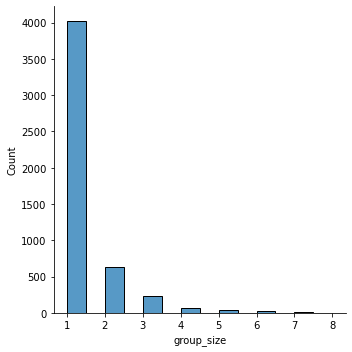

In [19]:
group_sizes = train.groupby(['group']).size().reset_index(name = "group_size")
display(group_sizes.head(3))
sns.displot(group_sizes, x='group_size')
plt.show()

In [20]:
df = group_sizes.groupby(['group_size']).size().reset_index(name='count')
df['%'] = ((df['count'] / df['count'].sum()) *100).round(2)
display(df.style.bar(subset=["count"], color='steelblue'))

,group_size,count,%
0,1,4021,80.180000
1,2,632,12.600000
2,3,235,4.690000
3,4,62,1.240000
4,5,34,0.680000
5,6,20,0.400000
6,7,10,0.200000
7,8,1,0.020000


adding **group_sizes** column to the train dataset

In [21]:
train = pd.merge(train, group_sizes, on='group')

adding **group, no_in_group**, and **group_size** to test dataset

In [22]:
test[['group', 'no_in_group']] = test['PassengerId'].str.split("_", expand = True)
group_sizes = test.groupby(['group']).size().reset_index(name = "group_size")
test = pd.merge(test, group_sizes, on='group')

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

In [23]:
train['CryoSleep'].value_counts()

False    4274
True     2332
Name: CryoSleep, dtype: int64

Converting to numeric values:
- False => 0
- True => 1

In [24]:
def CryoSleep(row):
    if row['CryoSleep'] == True:
        return 1
    else:
        return 0

train['CryoSleep'] = train.apply(CryoSleep, axis = 1)
test['CryoSleep'] = test.apply(CryoSleep, axis = 1)

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [25]:
# number of unique values
len(train['Cabin'].unique())

5305

In [26]:
train[['deck', 'num','side']] = train['Cabin'].str.split("/", expand = True)
test[['deck', 'num','side']] = test['Cabin'].str.split("/", expand = True)

Number of decks

In [27]:
df = train['deck'].value_counts().reset_index(name='count')
df['%'] = ((df['count'] / df['count'].sum()) *100).round(2)
df.columns = ['deck', 'count', '%']
df

,deck,count,%
0,F,2152,32.58
1,G,1973,29.87
2,E,683,10.34
3,B,628,9.51
4,C,587,8.89
5,D,374,5.66
6,A,207,3.13
7,T,2,0.03


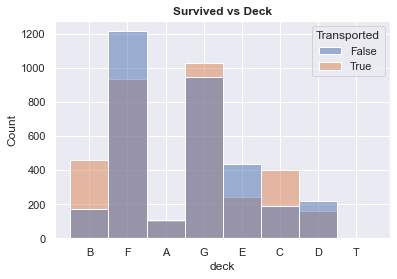

In [28]:
sns.set_theme()
sns.histplot(train, x="deck", hue="Transported")
plt.title("Survived vs Deck", fontweight='bold')
plt.show()

Convertic decks to numeric values

In [29]:
code = list(train['deck'].unique())
code.sort()
code_dic = { code[i]:i for i in range(len(code))}
code_dic

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}

In [30]:
def deck(row):
    return code_dic[row['deck']]

train['deck'] = train.apply(deck, axis = 1)
test['deck'] = test.apply(deck, axis = 1)

In [31]:
train['deck'].unique()

array([1, 5, 0, 6, 4, 2, 3, 7], dtype=int64)

Convertic sides to numeric values:
- S => 0
- P => 1

In [32]:
train['side'].value_counts()

S    3345
P    3261
Name: side, dtype: int64

In [33]:
def side(row):
    if row['side'] == 'S':
        return 0
    else:
        return 1

train['side'] = train.apply(side, axis = 1)
test['side'] = test.apply(side, axis = 1)

In [34]:
train['side'].unique()

array([1, 0], dtype=int64)

**Age** - The age of the passenger.

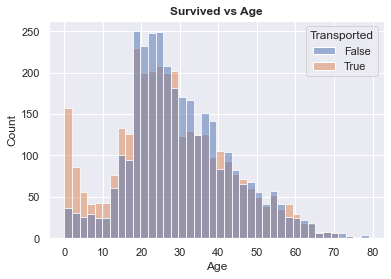

In [35]:
sns.set_theme()
sns.histplot(train, x="Age", hue="Transported")
plt.title("Survived vs Age", fontweight='bold')

plt.show()

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

In [36]:
train['VIP'].value_counts()

False    6444
True      162
Name: VIP, dtype: int64

Converting to numeric values:
- False => 0
- True => 1

In [37]:
def VIP(row):
    if row['VIP'] == True:
        return 1
    else:
        return 0

train['VIP'] = train.apply(CryoSleep, axis = 1)
test['VIP'] = test.apply(CryoSleep, axis = 1)

**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence. 

In [38]:
train['HomePlanet'].value_counts()

Earth     3566
Europa    1673
Mars      1367
Name: HomePlanet, dtype: int64

Converting to numeric values:
- Earth     0
- Europa    1
- Mars      2

In [39]:
code = list(train['HomePlanet'].unique())
code.sort()
code_dic = { code[i]:i for i in range(len(code))}
code_dic

{'Earth': 0, 'Europa': 1, 'Mars': 2}

In [40]:
def HomePlanet(row):
    return code_dic[row['HomePlanet']]

train['HomePlanet'] = train.apply(HomePlanet, axis = 1)
test['HomePlanet'] = test.apply(HomePlanet, axis = 1)

In [41]:
train['HomePlanet'].value_counts()

0    3566
1    1673
2    1367
Name: HomePlanet, dtype: int64

**Destination** - The planet the passenger will be debarking to.

In [42]:
train['Destination'].value_counts()

TRAPPIST-1e      4576
55 Cancri e      1407
PSO J318.5-22     623
Name: Destination, dtype: int64

Converting to numeric values:
- 55 Cancri e ------- 0
- PSO J318.5-22 ----- 1
- TRAPPIST-1e ------- 2

In [43]:
code = list(train['Destination'].unique())
code.sort()
code_dic = { code[i]:i for i in range(len(code))}
code_dic

{'55 Cancri e': 0, 'PSO J318.5-22': 1, 'TRAPPIST-1e': 2}

In [44]:
def Destination(row):
    return code_dic[row['Destination']]

train['Destination'] = train.apply(Destination, axis = 1)
test['Destination'] = test.apply(Destination, axis = 1)

In [45]:
train['Destination'].value_counts()

2    4576
0    1407
1     623
Name: Destination, dtype: int64

#### Transported

In [46]:
df = train.groupby(['Transported'])['Transported'].count().reset_index(name = "count")
df['%'] = ((df['count'] / df['count'].sum()) *100).round(2)
display(df)

,Transported,count,%
0,False,3279,49.64
1,True,3327,50.36


Converting to numeric values:
- False => 0
- True => 1


In [47]:
def Transported(row):
    if row['Transported'] == True:
        return 1
    else:
        return 0

train['Transported'] = train.apply(Transported, axis = 1)

In [48]:
train.head(7)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group,no_in_group,group_size,deck,num,side
0,0001_01,1,0,B/0/P,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0001,01,1,1,0,1
1,0002_01,0,0,F/0/S,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,0002,01,1,5,0,0
2,0003_01,1,0,A/0/S,2,58.0,0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0003,01,2,0,0,0
3,0003_02,1,0,A/0/S,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0003,02,2,0,0,0
4,0004_01,0,0,F/1/S,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,0004,01,1,5,1,0
5,0005_01,0,0,F/0/P,1,44.0,0,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,1,0005,01,1,5,0,1
6,0006_01,0,0,F/2/S,2,26.0,0,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,1,0006,01,1,5,2,0


### Selecting feature set

In [49]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'group', 'no_in_group', 'group_size', 'deck',
       'num', 'side'],
      dtype='object')

In [50]:
train[['Transported','HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','group_size', 'deck', 'side']].head(5)

,Transported,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,group_size,deck,side
0,0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,1,1,1
1,1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,5,0
2,0,1,0,2,58.0,0,43.0,3576.0,0.0,6715.0,49.0,2,0,0
3,0,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,2,0,0
4,1,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,5,0


Defining feature sets, X; and converting the Pandas data frame to a Numpy array:

In [51]:
X = train[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','group_size', 'deck','side']].values
X[:5]

array([[1.000e+00, 0.000e+00, 2.000e+00, 3.900e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00],
       [0.000e+00, 0.000e+00, 2.000e+00, 2.400e+01, 0.000e+00, 1.090e+02,
        9.000e+00, 2.500e+01, 5.490e+02, 4.400e+01, 1.000e+00, 5.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.000e+00, 5.800e+01, 0.000e+00, 4.300e+01,
        3.576e+03, 0.000e+00, 6.715e+03, 4.900e+01, 2.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.000e+00, 3.300e+01, 0.000e+00, 0.000e+00,
        1.283e+03, 3.710e+02, 3.329e+03, 1.930e+02, 2.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 2.000e+00, 1.600e+01, 0.000e+00, 3.030e+02,
        7.000e+01, 1.510e+02, 5.650e+02, 2.000e+00, 1.000e+00, 5.000e+00,
        0.000e+00]])

In [52]:
y = train['Transported'].values
y[0:5]

array([0, 1, 0, 0, 1], dtype=int64)

### Normalizing Data

In [53]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 0.41742617, -0.73866414,  0.6330054 ,  0.69541256, -0.73866414,
        -0.34575616, -0.28535504, -0.30949367, -0.27375941, -0.26953392,
        -0.6098625 , -1.82903018,  1.0127976 ],
       [-0.83656077, -0.73866414,  0.6330054 , -0.33676885, -0.73866414,
        -0.17674796, -0.279993  , -0.26611234,  0.20616519, -0.23049418,
        -0.6098625 ,  0.4020793 , -0.98736411],
       [ 0.41742617, -0.73866414,  0.6330054 ,  2.00284235, -0.73866414,
        -0.2790832 ,  1.84516272, -0.30949367,  5.59635657, -0.22605785,
         0.1687907 , -2.38680755, -0.98736411],
       [ 0.41742617, -0.73866414,  0.6330054 ,  0.28254   , -0.73866414,
        -0.34575616,  0.47903374,  0.33428525,  2.63638446, -0.09829145,
         0.1687907 , -2.38680755, -0.98736411],
       [-0.83656077, -0.73866414,  0.6330054 , -0.8872656 , -0.73866414,
         0.12405563, -0.24365028, -0.04747044,  0.22015206, -0.26775938,
        -0.6098625 ,  0.4020793 , -0.98736411]])

### Train Test Split

In [54]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (5284, 13) (5284,)
Test set: (1322, 13) (1322,)


In [55]:
from sklearn.neighbors import KNeighborsClassifier

### Predicting KNN

In [56]:
k = 4
# training model with k-4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=4)

In [57]:
# creating predictions
yhat = neigh.predict(X_test)
yhat[0:5]

array([0, 1, 1, 0, 0], dtype=int64)

### Accuracy evaluation KNN

In [58]:
from sklearn import metrics
print("Train set - Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set data created from split - Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set - Accuracy:  0.8389477668433005
Test set data created from split - Accuracy:  0.7632375189107413


### Checking more K

In [59]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks): 
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(list(mean_acc))

[0.7397881996974282, 0.7503782148260212, 0.7708018154311649, 0.7632375189107413, 0.7760968229954615, 0.7760968229954615, 0.7806354009077155, 0.7844175491679274, 0.7859304084720121]


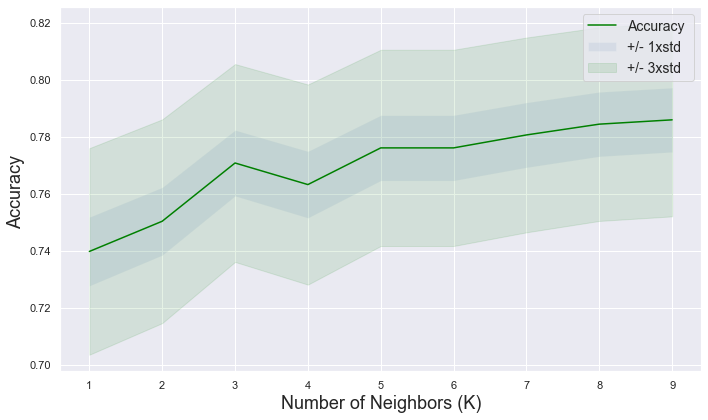

In [60]:
fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
ax.plot(range(1,Ks),mean_acc,'green')
ax.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
ax.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
ax.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'), fontsize=14)
plt.ylabel('Accuracy ', fontsize=18)
plt.xlabel('Number of Neighbors (K)', fontsize=18)
plt.tight_layout()
plt.show()

In [61]:
print( "The best accuracy is with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy is with 0.7859304084720121 with k= 9


### Confusion Matrix KNN

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
cnf_matrix

array([[517, 153],
       [130, 522]], dtype=int64)

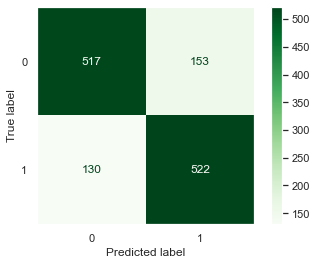

In [63]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot(cmap='Greens')
plt.grid(False)
plt.show()

# Decision Tree

In [64]:
from sklearn.tree import DecisionTreeClassifier

- Sklearn Decision Trees doesn't handle categorical variables. This is fine because we converted the categorical variables to numerical ones before.

#### Selecting feature set

In [65]:
display(train[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','group_size', 'deck','side']].head(1))

X = train[['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','group_size', 'deck','side']].values
X[:5]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,group_size,deck,side
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,1,1,1


array([[1.000e+00, 0.000e+00, 2.000e+00, 3.900e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00],
       [0.000e+00, 0.000e+00, 2.000e+00, 2.400e+01, 0.000e+00, 1.090e+02,
        9.000e+00, 2.500e+01, 5.490e+02, 4.400e+01, 1.000e+00, 5.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.000e+00, 5.800e+01, 0.000e+00, 4.300e+01,
        3.576e+03, 0.000e+00, 6.715e+03, 4.900e+01, 2.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.000e+00, 3.300e+01, 0.000e+00, 0.000e+00,
        1.283e+03, 3.710e+02, 3.329e+03, 1.930e+02, 2.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 2.000e+00, 1.600e+01, 0.000e+00, 3.030e+02,
        7.000e+01, 1.510e+02, 5.650e+02, 2.000e+00, 1.000e+00, 5.000e+00,
        0.000e+00]])

#### Selecting target values

In [66]:
y = train['Transported'].values
y[0:5]

array([0, 1, 0, 0, 1], dtype=int64)

#### Splitting data

In [67]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (5284, 13) (5284,)
Test set: (1322, 13) (1322,)


### creating instance of the Decision Tree Classifier  max_depth = 4

In [68]:
dec_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [69]:
dec_tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

#### Prediction  - Decision Tree

In [70]:
pred_tree = dec_tree.predict(X_test)

In [71]:
print (pred_tree [0:5])
print (y_test [0:5])

[1 1 1 0 0]
[1 1 1 0 0]


#### Evaluation of the model - Decision Tree

In [72]:
print("DecisionTrees's Accuracy - test split: ", metrics.accuracy_score(y_test, pred_tree))

DecisionTrees's Accuracy - test split:  0.7632375189107413


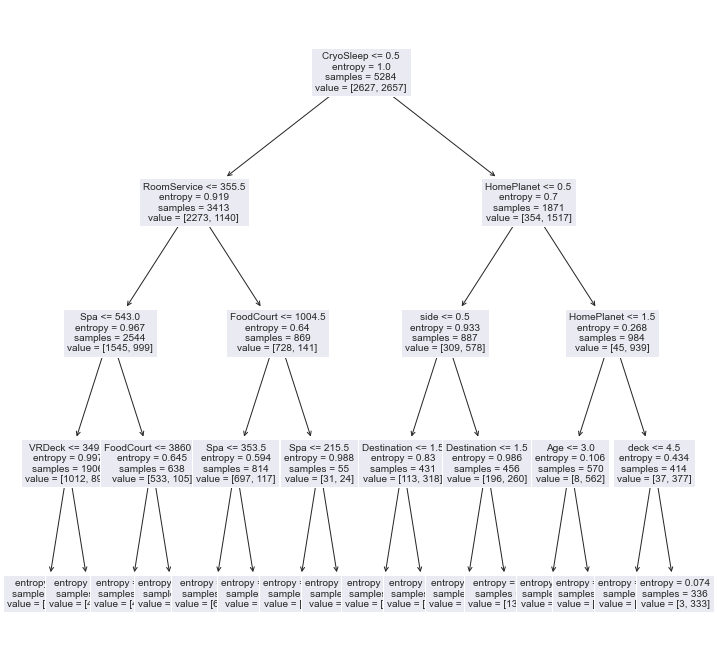

In [73]:
import sklearn.tree as tree

features = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','group_size', 'deck','side']
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(dec_tree, fontsize=10, feature_names=features)
plt.show()

### Decision Tree Classifier max_depth = 6

In [74]:
dec_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
dec_tree.fit(X_train,y_train)
pred_tree = dec_tree.predict(X_test)
print("DecisionTrees's Accuracy - test split: ", metrics.accuracy_score(y_test, pred_tree))

DecisionTrees's Accuracy - test split:  0.7866868381240545
